<a href="https://colab.research.google.com/github/Yutong-Lu/Datathon-5/blob/main/Pourya_Datathon5_DownSampling_ClassWeights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Yutong-Lu/Datathon-5.git

Cloning into 'Datathon-5'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 29 (delta 14), reused 5 (delta 1), pack-reused 0
Receiving objects: 100% (29/29), 665.77 KiB | 2.16 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
cd ./Datathon-5

/content/Datathon-5


In [ ]:
cd ..

/content


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch as t
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import warnings

In [ ]:
# Load the CSV file into a DataFrame
file_path = 'mhealth.csv'
df = pd.read_csv(file_path)

df.head()

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.44902,-1.0103,0.034483,0,subject1
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,0,subject1
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,0,subject1
3,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-8.6279,-4.3163,0.367520,-0.45686,-1.0082,0.025862,0,subject1
4,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,-8.7008,-4.1459,0.407290,-0.45686,-1.0082,0.025862,0,subject1


In [ ]:
df.shape

(999999, 14)

In [ ]:
# no missing value
df.isnull().sum()

alx         0
aly         0
alz         0
glx         0
gly         0
glz         0
arx         0
ary         0
arz         0
grx         0
gry         0
grz         0
Activity    0
subject     0
dtype: int64

In [ ]:
# Check the number of sequence for each person
df['subject'].value_counts()

subject1    161280
subject2    130561
subject8    129024
subject3    122112
subject5    119808
subject4    116736
subject7    104448
subject6     98304
subject9     17726
Name: subject, dtype: int64

In [ ]:
# Check activity frequency
activity_counts = df['Activity'].value_counts()
activity_counts

0     720946
1      27648
2      25406
3      24576
4      24576
9      24576
10     24576
11     24576
5      24576
7      23809
8      23501
6      22990
12      8243
Name: Activity, dtype: int64

In [ ]:
majority_class = df['Activity'].value_counts().idxmax()

# Separate majority class and other classes
majority_data = df[df['Activity'] == majority_class]
other_classes_data = df[df['Activity'] != majority_class]

# Determine the size of the majority class
majority_size = len(majority_data)

# Downsampling the majority class
downsampled_majority = majority_data.sample(n=majority_size // 30, random_state=42)  # Downsample to half the size

# Combine the downsampled majority class with other classes
df = pd.concat([downsampled_majority, other_classes_data])

In [ ]:
# Calculate the total number of samples
total_samples = df['Activity'].value_counts().sum()

# Calculate inverse frequencies for each activity
inverse_frequencies = total_samples / (len(activity_counts) * activity_counts)
class_weights = t.tensor(inverse_frequencies.values, dtype=t.float32)
class_weights

tensor([0.0323, 0.8432, 0.9177, 0.9487, 0.9487, 0.9487, 0.9487, 0.9487, 0.9487,
        0.9792, 0.9920, 1.0141, 2.8284])

In [ ]:
data_crosstab = pd.crosstab(df['subject'], df['Activity'], margins = False)
print(data_crosstab)

Activity    0     1     2     3     4     5     6     7     8     9     10  \
subject                                                                      
subject1  4214  3072  3072  3072  3072  3072  3072  3072  3379  3072  3072   
subject2  3192  3072  3072  3072  3072  3072  3174  3328  3430  3072  3072   
subject3  2878  3072  3072  3072  3072  3072  3226  3379  3175  3072  3072   
subject4  2662  3072  3072  3072  3072  3072  3328  3277  3123  3072  3072   
subject5  2896  3072  3072  3072  3072  3072  2765  2868  2714  3072  3072   
subject6  2248  3072  3072  3072  3072  3072  2202  2099  2304  3072  3072   
subject7  2326  3072  3072  3072  3072  3072  3072  2765  2816  3072  3072   
subject8  3116  3072  3072  3072  3072  3072  2151  3021  2560  3072  3072   
subject9   499  3072   830     0     0     0     0     0     0     0     0   

Activity    11    12  
subject               
subject1  3072  1075  
subject2  3072  1024  
subject3  3072  1024  
subject4  3072  1024  
sub

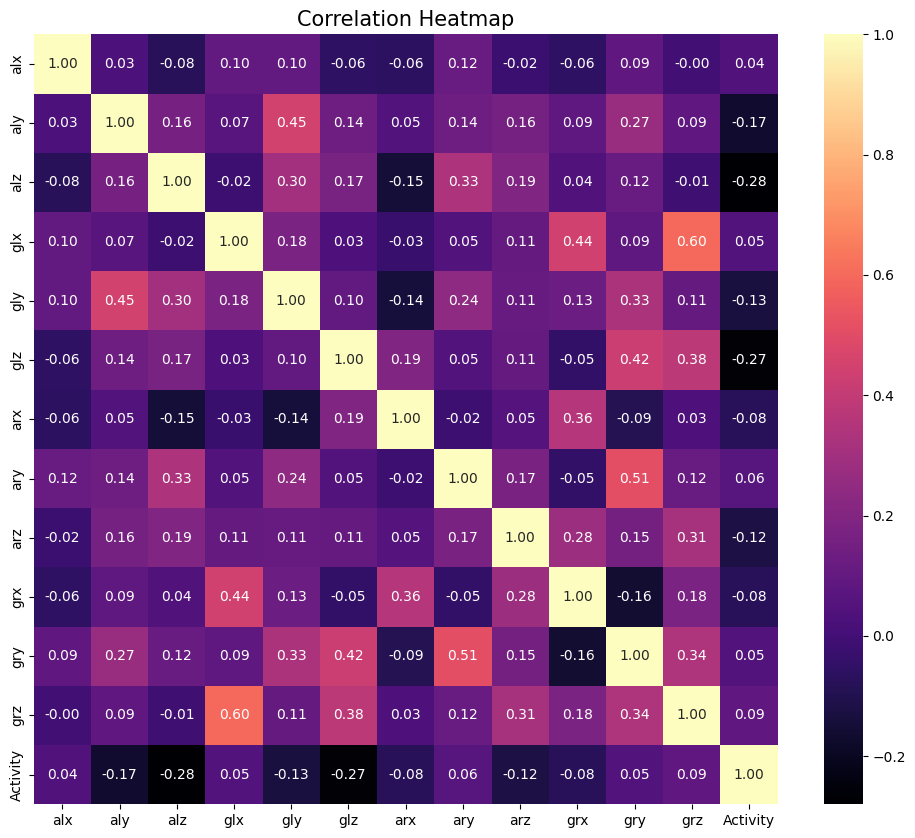

In [ ]:
correlation_matrix = df.corr(numeric_only=True)

# Plot the updated correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='magma')
plt.title('Correlation Heatmap', fontsize=15)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Grouping by 'patient_nbr' and creating a list of dataframes, one per group
grouped = df.groupby('subject')
grouped_dfs = [group for _, group in grouped]

In [ ]:
from sklearn.preprocessing import StandardScaler

train_sets = []
test_sets = []
validation_sets = []
for i in range(len(grouped_dfs)):
    # Splitting the groups into training and test sets with an 80:20 ratio
    train_set, test_set = train_test_split(grouped_dfs[i], test_size=0.2, random_state=42)
    train_set, validation_set = train_test_split(train_set, test_size=0.2, random_state=42)
    print(np.shape(train_set), np.shape(test_set), np.shape(validation_set))
    numerical_columns = train_set.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numerical_columns.remove('Activity')  # Assuming 'Activity' is the target variable

    scaler = StandardScaler()
    train_set[numerical_columns] = scaler.fit_transform(train_set[numerical_columns])
    validation_set[numerical_columns] = scaler.transform(validation_set[numerical_columns])
    test_set[numerical_columns] = scaler.transform(test_set[numerical_columns])
    train_sets.append(train_set)
    test_sets.append(test_set)
    validation_sets.append(validation_set)

(25208, 14) (7878, 14) (6302, 14)
(24783, 14) (7745, 14) (6196, 14)
(24484, 14) (7652, 14) (6122, 14)
(24313, 14) (7598, 14) (6079, 14)
(23579, 14) (7369, 14) (5895, 14)
(22049, 14) (6891, 14) (5513, 14)
(23410, 14) (7316, 14) (5853, 14)
(23326, 14) (7290, 14) (5832, 14)
(2816, 14) (881, 14) (704, 14)


Create sequence for training set

In [ ]:
numerical_features = [
    col for col in df.select_dtypes(include=[np.number]).columns
    if col != 'Activity'
]

def create_sequences(data, sequence_length=100):
    sequences = []
    output = []
    for i in range(0, len(data) - sequence_length + 1, sequence_length):
        sequence = data[i:i + sequence_length]
        # Assuming 'Activity' is the target variable and is the same for the entire sequence
        label = sequence['Activity'].iloc[0]
        sequences.append(sequence[numerical_features].values)
        output.append(label)

    return np.array(sequences), np.array(output)

In [ ]:
# Creating sequences for training and test data
X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []
X_validation_list = []
y_validation_list = []

for i in range(len(train_sets)):
    X_train, y_train = create_sequences(train_sets[i], sequence_length=100)
    X_test, y_test = create_sequences(test_sets[i], sequence_length=100)
    X_validation, y_validation = create_sequences(validation_sets[i], sequence_length=100)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_validation.shape, y_validation.shape)
    X_train_list.append(X_train)
    y_train_list.append(y_train)
    X_test_list.append(X_test)
    y_test_list.append(y_test)
    X_validation_list.append(X_validation)
    y_validation_list.append(y_validation)

(252, 100, 12) (252,) (78, 100, 12) (78,) (63, 100, 12) (63,)
(247, 100, 12) (247,) (77, 100, 12) (77,) (61, 100, 12) (61,)
(244, 100, 12) (244,) (76, 100, 12) (76,) (61, 100, 12) (61,)
(243, 100, 12) (243,) (75, 100, 12) (75,) (60, 100, 12) (60,)
(235, 100, 12) (235,) (73, 100, 12) (73,) (58, 100, 12) (58,)
(220, 100, 12) (220,) (68, 100, 12) (68,) (55, 100, 12) (55,)
(234, 100, 12) (234,) (73, 100, 12) (73,) (58, 100, 12) (58,)
(233, 100, 12) (233,) (72, 100, 12) (72,) (58, 100, 12) (58,)
(28, 100, 12) (28,) (8, 100, 12) (8,) (7, 100, 12) (7,)


In [ ]:
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)
X_validation = np.concatenate(X_validation_list, axis=0)
y_validation = np.concatenate(y_validation_list, axis=0)
print(np.shape(X_train), np.shape(y_train), np.shape(X_test), np.shape(y_test), np.shape(X_validation), np.shape(y_validation))

(1936, 100, 12) (1936,) (600, 100, 12) (600,) (481, 100, 12) (481,)


In [ ]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Model, self).__init__()

        self.rnn_layer1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(0.5)
        self.rnn_layer2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(0.5)
        self.fc_layer1 = nn.Linear(hidden_size, hidden_size)
        self.batch_normalization = nn.BatchNorm1d(hidden_size)
        self.fc_layer2 = nn.Linear(hidden_size, hidden_size * 2)
        self.batch_normalization2 = nn.BatchNorm1d(hidden_size * 2)
        self.fc_layer3 = nn.Linear(hidden_size * 2, hidden_size)
        self.batch_normalization3 = nn.BatchNorm1d(hidden_size)
        self.fc_layer4 = nn.Linear(hidden_size, hidden_size // 2)
        self.batch_normalization4 = nn.BatchNorm1d(hidden_size // 2)
        self.fc_layer5 = nn.Linear(hidden_size // 2, num_classes)
        self.dropout_fc = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        out, _ = self.rnn_layer1(x)
        out = self.dropout1(out)
        out, _ = self.rnn_layer2(out)
        out = self.dropout2(out)
        out = out[:, -1, :]
        out = self.relu(self.fc_layer1(out))
        out = self.batch_normalization(out)
        out = self.relu(self.fc_layer2(out))
        out = self.batch_normalization2(out)
        out = self.dropout_fc(out)
        out = self.relu(self.fc_layer3(out))
        out = self.batch_normalization3(out)
        out = self.relu(self.fc_layer4(out))
        out = self.batch_normalization4(out)
        out = self.dropout_fc(out)
        out = self.fc_layer5(out)
        return out

In [ ]:
input_size = X_train.shape[2]
hidden_size = 256
num_classes = 13
learning_rate = 0.001
batch_size = 256

# Create an instance of the model
model = Model(input_size, hidden_size, num_classes)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Data preparation
train_dataset = TensorDataset(t.tensor(X_train, dtype=t.float32), t.tensor(y_train, dtype=t.long))
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = TensorDataset(t.tensor(X_validation, dtype=t.float32), t.tensor(y_validation, dtype=t.long))
validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(t.tensor(X_test, dtype=t.float32), t.tensor(y_test, dtype=t.long))
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Lists to store accuracies and losses
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

best_validation_accuracy = 0.0
best_model_state = None
epochs = 50

# Training loop
for epoch in range(epochs):
    if epoch % 10 == 0:
        learning_rate *= 0.95  # Learning rate scheduling

    per_epoch_loss_list = []
    for X, Y in train_data_loader:
        # Forward pass through the model
        out = model(X)

        # Loss calculation
        loss = loss_fn(out, Y)
        per_epoch_loss_list.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        per_epoch_loss_list.append(loss.item())


    # Evaluation on training and validation data
    model.eval()

    with t.no_grad():
        # Training data
        train_correct, train_total = 0, 0
        for X, Y in train_data_loader:
            out = model(X)
            _, predicted = t.max(out.data, 1)
            train_total += Y.size(0)
            train_correct += (predicted == Y).sum().item()
        train_accuracy = 100 * train_correct / train_total

        # Validation data
        validation_correct, validation_total = 0, 0
        for X, Y in validation_data_loader:
            out = model(X)
            _, predicted = t.max(out.data, 1)
            validation_total += Y.size(0)
            validation_correct += (predicted == Y).sum().item()
        validation_accuracy = 100 * validation_correct / validation_total

        # Track best model and its state
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            best_model_state = {
                'model': model.state_dict(),
            }

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, Validation Accuracy: {validation_accuracy}%')

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

    # Set the model back to train mode
    model.train()


t.save(best_model_state, 'best_model.pth')

Epoch 0/50 ---> Train Accuracy: 8.316115702479339%, Validation Accuracy: 8.731808731808732%


In [ ]:
# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Load the best model parameters
best_model_state = t.load('best_model.pth')

# Initialize a new model with the same architecture
best_model = Model(input_size, hidden_size, num_classes)
best_model.load_state_dict(best_model_state)

# Set the best model to evaluation mode
best_model.eval()

# Loop through the test data and evaluate using the best model
with t.no_grad():
    test_correct = 0
    test_total = 0
    for X_test, Y_test in test_data_loader:
        out = best_model(X_test)
        _, predicted = t.max(out.data, 1)
        test_total += Y_test.size(0)
        test_correct += (predicted == Y_test).sum().item()
    test_accuracy = 100 * test_correct / test_total

# Print or use the test accuracy
print(f'Test Accuracy: {test_accuracy}%')


In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(test_targets, test_predictions)
print('Confusion Matrix:')
print(conf_matrix)